In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
from datetime import timedelta
%matplotlib inline 

In [2]:
def transaction_forecast(credit_account, amount, Goal = False,
                         debit_account = "Checking", 
                         end_date = datetime.date(1982+100,1,1),
                         start_date = datetime.datetime.now().date(),
                         period = "Monthly",
                         interest = False,
                         starting_value = 0,
                         rate = 0,
                         start_value_placement = False
                         ):
    '''Transaction_Forecast will create a list of transactions in
       two different accounts. It can be used to create a certain
       fixed amount of payments or calculate payments that equal a
       a certain amount.'''
    
    transaction_list = []
    transaction_list = []
    #Monthly Logic
    #Bi Weekly Logic
    #Weekly Logic
    #Daily Logic
    regularizer = 0
    if period == "Monthly":
        period_length = 30 #days
        regularizer = 1
        rate = rate/12*(1-.04)
    elif period == 'Bi-Weekly':
        period_length = 14 #days
        rate = rate/(52/2)*(1-.04)
    elif period == 'Weekly':
        period_length = 7 #days
        rate = rate/(52)*(1-.04)
    
    number_of_days = (end_date - start_date).days
    
    number_of_periods = number_of_days/period_length
    
    initial_day = start_date.day
    
    if Goal == True:
        amount = amount/(int(number_of_periods) + 1)
    
    
    if (starting_value > 0 or starting_value < 0) and start_value_placement == True:
        transaction_list.append({
            "Account":credit_account,
            "Credit_Amount":starting_value,
            "Date":start_date,
            "Debit_Amount":0
        })
    balance = starting_value
    
    for x in range(1,int(number_of_periods)+1):
        
        
        transaction_date = (start_date+timedelta(days = period_length*x)) \
                            - timedelta(days = (start_date+timedelta(days = period_length*x)).day)*regularizer\
                            + timedelta(days=initial_day)*regularizer
        
        if interest == True:

            interest = balance * rate
            balance = balance + interest + amount 
            
            #Insert Debit Transaction    #INTEREST
            transaction_list.append({
                "Account":credit_account + " Interest",
                "Debit_Amount":interest,
                "Date":transaction_date,
                "Credit_Amount":0
            })

            #Insert Credit Transaction   # INTEREST
            transaction_list.append({
                "Account":credit_account,
                "Credit_Amount":interest,
                "Date":transaction_date,
                "Debit_Amount":0
            })
            interest = True
        
   
        #print(x, amount, transaction_date)
        #Insert Debit Transaction
        transaction_list.append({
            "Account":debit_account,
            "Debit_Amount":amount,
            "Date":transaction_date,
            "Credit_Amount":0
        })

        #Insert Credit Transaction
        transaction_list.append({
            "Account":credit_account,
            "Credit_Amount":amount,
            "Date":transaction_date,
            "Debit_Amount":0
        })
    return transaction_list        



f01k = transaction_forecast(credit_account="401k",amount=530, rate = .08, starting_value = 43000,
                                  end_date = datetime.date(1970+65,1,1), debit_account="Income"
                           ,interest = True)

pd.DataFrame(f01k).head(3)


,Account,Credit_Amount,Date,Debit_Amount
0,401k Interest,0.0,2019-11-06,275.2
1,401k,275.2,2019-11-06,0.0
2,Income,0.0,2019-11-06,530.0


Next few months


"\nacct_forecasts[acct_forecasts.index < datetime.date(2019+5,1,1)][['Checking','ZeroLine','Ring','Wedding','House','School']].plot( figsize=(15,5))\n\nacct_forecasts[acct_forecasts.index < datetime.date(2019+10,1,1)][['Checking','401k','ZeroLine','House']].plot( figsize=(15,5))\n\nacct_forecasts[acct_forecasts.index < datetime.date(2019+50,1,1)][['Checking','401k','ZeroLine','Mortgage']].plot( figsize=(15,5))\n"

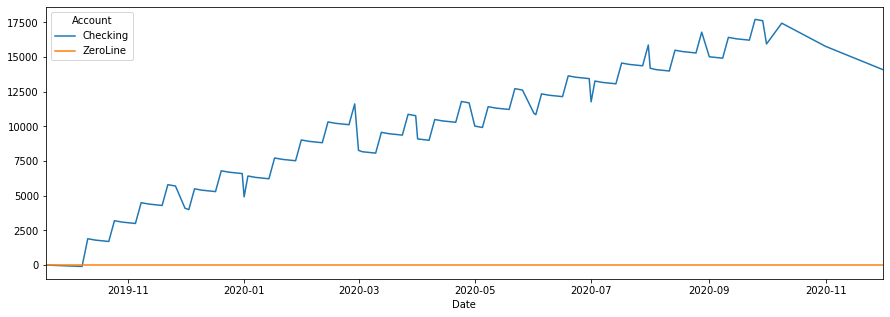

In [9]:
t_df = []
#t_df.append({"Account":"Checking",
#            "Debit_Amount":0,
#            "Date":datetime.date(2019,1,1),
#            "Credit_Amount":6299})

#t_df.append({"Account":"360MMA",
#            "Debit_Amount":0,
#            "Date":datetime.date(2019,1,1),
#            "Credit_Amount":10000})

t_df.append({"Account":"ZeroLine",
            "Debit_Amount":0,
            "Date":datetime.date(2019,9,19),
            "Credit_Amount":10})
t_df.append({"Account":"ZeroLine",
            "Debit_Amount":0,
            "Date":datetime.date(2019,9,19),
            "Credit_Amount":-10})
stream_sheet = pd.read_excel("Sample Finance Data.xlsx")
for item in range(stream_sheet.shape[0]):
    stream = stream_sheet.iloc[item]
    if "IGNORE" not in stream.Notes:
        t_df += transaction_forecast(debit_account=stream.Debit_Account,
                                     credit_account=stream.Credit_Account, 
                                     amount = stream.Amount,
                                    start_date = stream["Start Time"].date(),
                                    end_date=stream["End Time"].date(),
                                    rate = stream.Rate,
                                    interest = stream.Interest,
                                    starting_value = stream.Starting_Value,
                                    Goal = stream['Goal?'],
                                    period = stream.Period,
                                    start_value_placement = stream.Starting_Value_Placement)
    
    
#t_df += transaction_forecast(credit_account="401k",amount=530, rate = .08, starting_value = 43000,
#                                  end_date = datetime.date(1970+65,9,30), debit_account="Income"
#                           ,interest = True)
    
    
transaction_history = pd.DataFrame([item for item in t_df])

transaction_history["Delta"] = transaction_history.Credit_Amount - transaction_history.Debit_Amount

trxn_hist_by_acct = pd.DataFrame.pivot_table(transaction_history,values = "Delta",index = 'Date', 
                         aggfunc=np.sum, columns="Account",
                        fill_value = 0)


acct_forecasts = trxn_hist_by_acct.cumsum(axis = 0) 



print("Next few months")
acct_forecasts[acct_forecasts.index < datetime.date(2019+2,1,1)]\
[['Checking','ZeroLine']].plot( figsize=(15,5))

'''
acct_forecasts[acct_forecasts.index < datetime.date(2019+5,1,1)]\
[['Checking','ZeroLine','Ring','Wedding','House','School']].plot( figsize=(15,5))

acct_forecasts[acct_forecasts.index < datetime.date(2019+10,1,1)]\
[['Checking','401k','ZeroLine','House']].plot( figsize=(15,5))

acct_forecasts[acct_forecasts.index < datetime.date(2019+50,1,1)]\
[['Checking','401k','ZeroLine','Mortgage']].plot( figsize=(15,5))
'''